In [1]:
import sys

sys.path.append("..")

import pandas as pd
import kornia.augmentation as K
import torch
import torch.nn as nn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier, LogisticRegression

from src.models import get_model_by_name
from src.datasets.eurosat import EuroSATMinimal
from src.utils import extract_features

import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda:1")

In [5]:
# Fit and save features
model_names = [
    "resnet50_pretrained_imagenet",
    "resnet50_pretrained_seco",
    #"resnet50_pretrained_moco",
]
rgb = True
size = 224

columns = {
    "model_name": [],
    "rgb": [],
    "size": [],
    "train_pct": [],
    "knn5_accuracy": [],
    "knn5_scaled_accuracy": [],
    "linear_accuracy": [],
    "linear_scaled_accuracy": [],
    "linear_no_penalty_accuracy": [],
}

for model_name in model_names:
    print(model_name)
    if model_name == "resnet50_pretrained_seco":
        normalization = "for_seco"
    elif model_name == "resnet50_pretrained_moco":
        normalization = "divide"
    elif model_name == "resnet50_pretrained_imagenet":
        normalization = "standardization"

    for train_pct in [0.005, 0.007, 0.009, 0.01, 0.03, 0.05, 0.1, 0.2, 0.5, 1.0]:

        transforms = nn.Sequential(K.Resize(size)).to(device)
        dm = EuroSATMinimal(
            root="../data/eurosat/",
            band_set="rgb" if rgb else "all",
            normalization_method=normalization,
            batch_size=64,
            num_workers=8,
            train_pct=train_pct,
            use_both_trainval=False,
        )
        dm.setup()

        model = get_model_by_name(model_name, rgb, device=device, dataset=dm.train_dataset)

        x_train, y_train = extract_features(
            model, dm.train_dataloader(), device, transforms=transforms, verbose=False
        )
        x_test, y_test = extract_features(
            model, dm.test_dataloader(), device, transforms=transforms, verbose=False
        )

        knn_model = KNeighborsClassifier(n_neighbors=5)
        knn_model.fit(x_train, y_train)
        knn_acc = knn_model.score(x_test, y_test)

        linear_model = LogisticRegression(max_iter=3000)
        linear_model.fit(x_train, y_train)
        linear_acc = linear_model.score(x_test, y_test)

        linear_model = LogisticRegression(penalty=None, max_iter=3000)
        linear_model.fit(x_train, y_train)
        linear_no_penalty_acc = linear_model.score(x_test, y_test)

        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        knn_model = KNeighborsClassifier(n_neighbors=5)
        knn_model.fit(x_train, y_train)
        knn_scaled_acc = knn_model.score(x_test, y_test)

        linear_model = LogisticRegression(max_iter=3000)
        linear_model.fit(x_train, y_train)
        linear_scaled_acc = linear_model.score(x_test, y_test)


        print(model_name, train_pct, knn_acc, knn_scaled_acc, linear_no_penalty_acc, linear_acc, linear_scaled_acc)

        columns["model_name"].append(model_name)
        columns["rgb"].append(rgb)
        columns["size"].append(size)
        columns["train_pct"].append(train_pct)
        columns["knn5_accuracy"].append(knn_acc)
        columns["knn5_scaled_accuracy"].append(knn_scaled_acc)
        columns["linear_no_penalty_accuracy"].append(linear_no_penalty_acc)
        columns["linear_accuracy"].append(linear_acc)
        columns["linear_scaled_accuracy"].append(linear_scaled_acc)

resnet50_pretrained_imagenet
resnet50_pretrained_imagenet 0.005 0.6203703703703703 0.41833333333333333 0.7705555555555555 0.7587037037037037 0.7374074074074074
resnet50_pretrained_imagenet 0.007 0.6275925925925926 0.3262962962962963 0.8053703703703704 0.7948148148148149 0.7707407407407407
resnet50_pretrained_imagenet 0.009 0.7155555555555555 0.4338888888888889 0.8383333333333334 0.8492592592592593 0.8398148148148148
resnet50_pretrained_imagenet 0.01 0.7459259259259259 0.44722222222222224 0.832037037037037 0.8472222222222222 0.8298148148148148
resnet50_pretrained_imagenet 0.03 0.8038888888888889 0.5990740740740741 0.8825925925925926 0.9053703703703704 0.9024074074074074
resnet50_pretrained_imagenet 0.05 0.8192592592592592 0.6196296296296296 0.904074074074074 0.9172222222222223 0.9161111111111111
resnet50_pretrained_imagenet 0.1 0.855925925925926 0.707962962962963 0.9135185185185185 0.9337037037037037 0.932962962962963
resnet50_pretrained_imagenet 0.2 0.8701851851851852 0.760925925925925

/opt/conda/envs/geospatiallib/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


resnet50_pretrained_seco 1.0 0.8622222222222222 0.875 0.9422222222222222 0.9474074074074074 0.9377777777777778


In [6]:
df = pd.DataFrame(columns)

In [7]:
df.to_csv("../results/eurosat_trainpctvs_performance.csv")

In [11]:
df

,model_name,rgb,size,train_pct,knn5_accuracy,knn5_scaled_accuracy,linear_accuracy,linear_scaled_accuracy,linear_no_penalty_accuracy
0,resnet50_pretrained_imagenet,True,224,0.005,0.620370,0.418333,0.758704,0.737407,0.770556
1,resnet50_pretrained_imagenet,True,224,0.007,0.627593,0.326296,0.794815,0.770741,0.805370
2,resnet50_pretrained_imagenet,True,224,0.009,0.715556,0.433889,0.849259,0.839815,0.838333
3,resnet50_pretrained_imagenet,True,224,0.010,0.745926,0.447222,0.847222,0.829815,0.832037
4,resnet50_pretrained_imagenet,True,224,0.030,0.803889,0.599074,0.905370,0.902407,0.882593
5,resnet50_pretrained_imagenet,True,224,0.050,0.819259,0.619630,0.917222,0.916111,0.904074
6,resnet50_pretrained_imagenet,True,224,0.100,0.855926,0.707963,0.933704,0.932963,0.913519
7,resnet50_pretrained_imagenet,True,224,0.200,0.870185,0.760926,0.947778,0.943148,0.940370
8,resnet50_pretrained_imagenet,True,224,0.500,0.899815,0.796667,0.956111,0.950926,0.947037
9,resnet50_pretrained_imagenet,True,224,1.000,0.913519,0.830741,0.964444,0.955000,0.957963


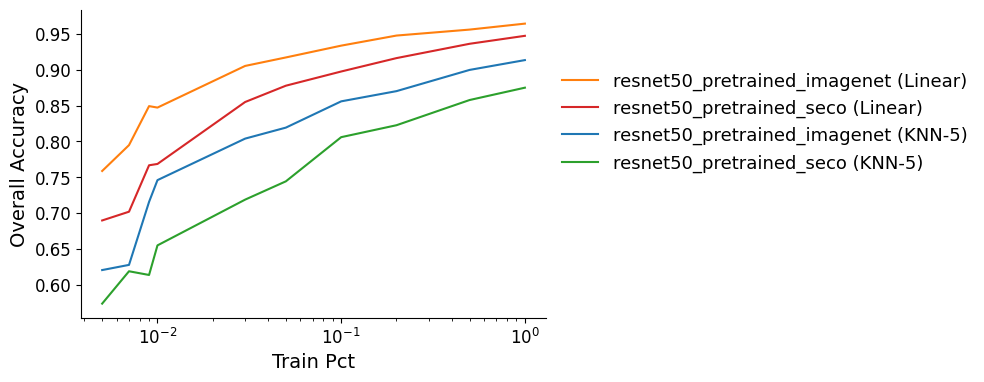

In [10]:
xs = sorted(df["train_pct"].unique())

plt.figure(figsize=(6, 4))

last_accs = []
for model_name, group in df.groupby("model_name"):
    # get best knn performance
    results = []
    use_scaled_knn = group["knn5_accuracy"].mean() < group["knn5_scaled_accuracy"].mean()
    for x in xs:
        if use_scaled_knn:
            results.append(group[group["train_pct"] == x]["knn5_scaled_accuracy"].values[0])
        else:
            results.append(group[group["train_pct"] == x]["knn5_accuracy"].values[0])
    plt.plot(xs, results, label=f"{model_name} (KNN-5)")
    last_accs.append(results[-1])

    # get best linear performance
    results = []
    use_scaled_linear = group["linear_accuracy"].mean() < group["linear_scaled_accuracy"].mean()
    for x in xs:
        if use_scaled_linear:
            results.append(group[group["train_pct"] == x]["linear_scaled_accuracy"].values[0])
        else:
            results.append(group[group["train_pct"] == x]["linear_accuracy"].values[0])
    plt.plot(xs, results, label=f"{model_name} (Linear)")
    last_accs.append(results[-1])

# remove right and top spines
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# xticks multiples of 32
plt.xticks(xs, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Overall Accuracy", fontsize=14)
plt.xlabel("Train Pct", fontsize=14)

# add legend off right side
# sort legend by order of performance
handles, labels = ax.get_legend_handles_labels()
order = np.argsort(last_accs)[::-1]
handles = [handles[i] for i in order]
labels = [labels[i] for i in order]
plt.legend(
    handles,
    labels,
    bbox_to_anchor=(1.0, 0.85),
    loc="upper left",
    fontsize=13,
    frameon=False,
)

plt.xscale("log")

plt.show()
plt.close()
